In this notebook, we see a very simple case on how our dataset can be used to evaluate the effectiveness of a fair ML intervention. We start with the definition of some simple data-loading and data-preprocessing functions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#First function to be called to load the collected dataset, with its biased and unbiased grades
def load_data_with_biased_and_unbiased_grades():
    raw_data_with_predictions = pd.read_csv("data/famous/CompleteDataAndBiases.csv", index_col="index")

    categorical_attributes = ["romantic", "reason"]
    return raw_data_with_predictions, categorical_attributes


#If desired some columns from the original dataset can be added to the dataset containing the fair and biased grades
def add_columns_from_org_data(columns_to_add, data_with_biased_and_fair_grades, categorical_attributes):
    categorical_attributes_org_data = {"school", "address", "famsize", "Pstatus", "Mjob", "Fjob", "guardian", "schoolsup",
                                       "famsup", "paid", "activities", "nursery", "higher", "internet", "subject"}
    raw_original_data = pd.read_csv("data/famous/original_data.csv")
    original_data_columns_to_add = original_data[columns_to_add].loc[data_with_biased_and_fair_grades.index]
    data_with_biased_and_fair_grades[columns_to_add] = original_data_columns_to_add

    categorical_attributes_added_to_data = categorical_attributes_org_data.intersection(set(columns_to_add))
    categorical_attributes.extend(list(categorical_attributes_added_to_data))

    return data_with_biased_and_fair_grades, categorical_attributes


#Preprocessing function: Here the raw data will be seperated into two dataframes. One contains all the information of the fair labels, while the other one contains 
#the same information with the biased grades. Which version of the biased grades is taken, dependens on the input for variable "binary_labels_conversion_strategy" 
#(either "Ranking" or "Pass-Fail"). 
def preprocess_data(data, categorical_attributes, one_hot_encoding=False, binary_labels_conversion_strategy = "Ranking"):
    """
    :param data: pandas Dataframe - Data containing the biased and unbiased version of the grades
    :param one_hot_encoding: boolean - Denotes whether one-hot-encoding should be part of the preprocessing or not
    :param categorical_attributes: list of string - List of all the categorical attribute names that will be one-hot-encoded if specified
    :param binary_labels_conversion_strategy: string - Specifies which version of the biased decision labels to use
    :return: pandas dataframe, pandas datframe - dataframe containing the fair version of the labels, dataframe containing the biased version of the labelste
    """
    if binary_labels_conversion_strategy == "Pass-Fail":
        biased_label_column = "Predicted_Pass_PassFailStrategy"
        other_biased_label_column = "Predicted_Pass_RankingStrategy"
    else:
        biased_label_column = "Predicted_Pass_RankingStrategy"
        other_biased_label_column = "Predicted_Pass_PassFailStrategy"
    
    data = data.drop(["ParticipantID", "name", "G3", "PredictedRank", "PredictedGrade", "StereotypeActivation"], axis=1) #"StereotypeActivation"

    if one_hot_encoding:
        one_hot = pd.get_dummies(data[categorical_attributes])
        data = data.drop(categorical_attributes, axis=1)
        data = data.join(one_hot)

    fair_data = data.copy()
    fair_data = fair_data.drop([biased_label_column, other_biased_label_column], axis=1)

    biased_data = data.drop(["Pass",  other_biased_label_column], axis=1)
    biased_data = biased_data.rename(columns={biased_label_column: "Pass"})

    return fair_data, biased_data


One of the fairness interventions we want to test is called **Massaging** [1], for which we include the implementation below.

The massaging approach works by training a classifier on the training set and observe the predicted probabilities for the labels of each instance: negative labels of protected instances, that lay close to the decision boundary, are changed to positive, while the opposite is done to the positive labels of unprotected instances close to the decision boundary. By making the distribution of positive labels more equal across the groups, a classifier trained on this debiased data, is expected to be more fair.

[1] Kamiran, F., & Calders, T. (2009, February). Classifying without discriminating. In *2009 2nd international conference on computer, control and communication* (pp. 1-6). IEEE.

In [2]:
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.svm import SVC


class Massaging:
    def __init__(self):
        pass

    def fit(self, X):
        train_data = pd.DataFrame(X.features, columns=X.feature_names)

        sensitive_attribute = X.protected_attributes.ravel()
        labels = X.labels.ravel()

        protected_indices = np.where(sensitive_attribute==0)[0]
        unprotected_indices = np.where(sensitive_attribute==1)[0]

        pos_decision_ratio_protected_indices = sum(labels[protected_indices])/len(protected_indices)
        pos_decision_ratio_unprotected_indices = sum(labels[unprotected_indices])/len(unprotected_indices)

        disc = pos_decision_ratio_unprotected_indices - pos_decision_ratio_protected_indices
        number_of_protected = len(protected_indices)
        number_of_unprotected = len(unprotected_indices)
        total_number_of_instances = len(train_data)

        #number of promotor, demotor pairs to achieve demographic parity
        M = round((disc * number_of_protected * number_of_unprotected)/total_number_of_instances)
        predicted_probabilities = self.learn_classifier(train_data, labels)

        predicted_probabilities_unprotected = pd.DataFrame(predicted_probabilities[unprotected_indices])
        predicted_probabilities_unprotected['Index'] = unprotected_indices

        predicted_probabilities_protected = pd.DataFrame(predicted_probabilities[protected_indices])
        predicted_probabilities_protected['Index'] = protected_indices

        if M>0:
            self.demotion_candidates = self.get_doubtful_positive_cases(predicted_probabilities_unprotected, labels[unprotected_indices], M)['Index']
            self.promotion_candidates = self.get_doubtful_negative_cases(predicted_probabilities_protected, labels[protected_indices], M)['Index']
        else:
            self.promotion_candidates = []
            self.demotion_candidates = []

        return

    def transform(self, X):
        transformed_data = X.copy(deepcopy=True)
        new_class_labels = X.labels.copy()

        np.put(new_class_labels, self.demotion_candidates, 0)
        np.put(new_class_labels, self.promotion_candidates, 1)

        transformed_data.labels = new_class_labels
        return transformed_data


    def learn_classifier(self, X, y):
        LR = LogisticRegression()
        LR.fit(X, y)
        predictions_probabilities = LR.predict_proba(X)
        return predictions_probabilities

    def order_instances(self, probability_labels):
        sort_by_probability = probability_labels.sort_values(1)
        sort_by_probability = sort_by_probability.reset_index(drop=True)
        return sort_by_probability


    # these are the cases of the unprotected indices that need to change
    def get_doubtful_positive_cases(self, probability_labels, class_labels, M):
        indices_with_positive_class_label = np.where(class_labels == 1)[0]
        probability_labels_of_positive_class_labels = probability_labels.iloc[indices_with_positive_class_label]
        sorted_probability_labels = self.order_instances(probability_labels_of_positive_class_labels)
        demotion_candidates = sorted_probability_labels.iloc[0: M]
        return demotion_candidates


    # these are the cases of the protected indices that need to change
    def get_doubtful_negative_cases(self, probability_labels, class_labels, M):
        indices_with_negative_class_label = np.where(class_labels == 0)[0]
        probability_labels_of_negative_class_labels = probability_labels.iloc[indices_with_negative_class_label]
        sorted_probability_labels = self.order_instances(probability_labels_of_negative_class_labels)
        promotion_candidates = sorted_probability_labels.iloc[-M:]
        return promotion_candidates


    def get_demotion_candidates(self):
        return self.demotion_candidates

    def get_promotion_candidates(self):
        return self.promotion_candidates


Implementation of the class **Classifier Tester**.

In these class all fairness interventions are tested (in combination with different classifiers) and their fairness as well as predictive performance are recorded.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import pandas as pd
import numpy as np
np.random.seed(5)


class ClassifierTester():
    def __init__(self, X_fair_train, X_fair_test, X_biased_train, X_biased_test):
        self.X_fair_train = X_fair_train
        self.X_fair_test = X_fair_test
        self.X_biased_train = X_biased_train
        self.X_biased_test = X_biased_test

    #An unfair classifier is simply trained on the biased version of the decision labels without applying any fairness intervention.
    def test_basic_unfair_classifiers(self, test_on_fair_test_set):
        print("\n\nTESTING UNFAIR CLASSIFIERS")
        features_X_train = self.X_biased_train.features
        labels_X_train = self.X_biased_train.labels.ravel()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set)
        performance_unfair_data_dataframe["Intervention"] = "Lower Baseline"
        return performance_unfair_data_dataframe

    
    #As an upper benchmark we test a classifier that is trained on the fair version of the decision labels
    def test_benchmark_fair_classifier(self, test_on_fair_test_set):
        print("\n\nTESTING FAIR CLASSIFIERS")
        features_X_train = self.X_fair_train.features
        labels_X_train = self.X_fair_train.labels.ravel()

        performance_fair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set)
        performance_fair_data_dataframe["Intervention"] = "Upper Baseline"
        return performance_fair_data_dataframe
    
    #"Fairness through Unawareness" is one of the most simplistic fairness interventions, where the sensitive attribute is simply removed from the training data
    def test_fairness_through_unawareness(self, test_on_fair_test_set):
        print("\n\nTESTING UNAWARENESS")

        feature_names = self.X_biased_train.feature_names
        index_sensitive_attribute = feature_names.index("sex")

        features_X_train = self.X_biased_train.features.copy()
        features_X_train_without_sensitive = np.delete(features_X_train, index_sensitive_attribute, 1)
        labels_X_train = self.X_biased_train.labels.ravel()

        performance_fairness_through_unawareness_dataframe = self.test_all_standard_classifiers(features_X_train_without_sensitive, labels_X_train,
                                                                                     test_on_fair_test_set, without_sensitive_attribute=True)
        performance_fairness_through_unawareness_dataframe["Intervention"] = "Unawareness"
        return performance_fairness_through_unawareness_dataframe

    #Here the Massaging Fairness Intervention is applied on the unfair data
    def test_massaging(self, test_on_fair_test_set):
        masseuse = Massaging()
        masseuse.fit(self.X_biased_train)
        preprocessed_X_train = masseuse.transform(self.X_biased_train)

        print("\n\nTESTING MASSAGING")
        features_X_train = preprocessed_X_train.features
        labels_X_train = preprocessed_X_train.labels.ravel()

        performance_massaging_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set)
        performance_massaging_dataframe["Intervention"] = "Massaging"
        return performance_massaging_dataframe, masseuse

    #For all fairness interventions we test three classifiers: A Support Vector Machine, a Random Forest and a Logistic Regression Classifier. 
    def test_all_standard_classifiers(self, X_train, y_train, test_on_fair_test_set, without_sensitive_attribute=False):
        if without_sensitive_attribute:
            features_X_test = self.X_biased_test.features.copy()
            features_X_test = np.delete(features_X_test, 0, 1)
        else:
            features_X_test = self.X_biased_test.features

        # logistic regression
        lr = LogisticRegression(max_iter=200)
        lr.fit(X_train, y_train)
        test_labels_pred_lr = lr.predict(features_X_test)
        test_labels_proba_lr = lr.predict_proba(features_X_test)
        lr_evaluation_dict = self.evaluation_on_labels(test_labels_pred_lr, test_labels_proba_lr, test_on_fair_test_set)

        # random forest
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        test_labels_pred_rf = rf.predict(features_X_test)
        test_labels_proba_rf = rf.predict_proba(features_X_test)
        rf_evaluation_dict = self.evaluation_on_labels(test_labels_pred_rf, test_labels_proba_rf, test_on_fair_test_set)

        # support vector machine
        svm = SVC(probability=True)
        svm.fit(X_train, y_train)
        test_labels_pred_svm = svm.predict(features_X_test)
        test_labels_proba_svm = svm.predict_proba(features_X_test)
        svm_evaluation_dict = self.evaluation_on_labels(test_labels_pred_svm, test_labels_proba_svm, test_on_fair_test_set)

        performances_of_interest = [lr_evaluation_dict, rf_evaluation_dict, svm_evaluation_dict]
        performance_dataframe = pd.DataFrame(performances_of_interest, index=["LR", "RF", "SVM"])
        return performance_dataframe

    #For each intervention+classifier combination, the performance is evaluated. Some measures of predictive performance (i.e. Accuracy, AUC score and F1 score) are 
    #calculated, as well as some fairness metric (i.e. Discrimination Score, difference in true positive rates and difference in false positive rates.)
    def evaluation_on_labels(self, test_label_predictions, test_probability_predictions, test_on_fair_set):
        if test_on_fair_set:
            ground_truth_labels = self.X_fair_test.labels.ravel()
            ground_truth_dataset = self.X_fair_test
        else:
            ground_truth_labels = self.X_biased_test.labels.ravel()
            ground_truth_dataset = self.X_biased_test

        test_pred_dataset = self.X_fair_test.copy()
        test_pred_dataset.labels = test_label_predictions

        privileged_groups = [{'sex': 1}]  # girls
        unprivileged_groups = [{'sex': 0}]  # boys

        accuracy = accuracy_score(ground_truth_labels, test_label_predictions)
        auc = roc_auc_score(ground_truth_labels, test_probability_predictions[:, 1])
        f1 = f1_score(ground_truth_labels, test_label_predictions)

        metric_org_test = BinaryLabelDatasetMetric(test_pred_dataset, unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

        diff_in_pos_ratio = metric_org_test.mean_difference()

        metric_org_vs_pred = ClassificationMetric(ground_truth_dataset, test_pred_dataset,
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)

        true_positive_rate_diff = metric_org_vs_pred.equal_opportunity_difference()
        false_positive_rate_diff = metric_org_vs_pred.false_positive_rate_difference()

        return {"Accuracy": accuracy, "F1": f1, "AUC": auc, "Discrimination Score": diff_in_pos_ratio, "TPR_diff": true_positive_rate_diff, "FPR_diff": false_positive_rate_diff}


    
    #All fairness interventions are called, and their (predictive + fairness) performances are stored in a dataframe
    def test_all_algorithms(self, test_on_fair_test_set=True):
        performance_fairness_through_unawareness = self.test_fairness_through_unawareness(test_on_fair_test_set)
        performance_upper_benchmark = self.test_benchmark_fair_classifier(test_on_fair_test_set)
        performance_lower_benchmark = self.test_basic_unfair_classifiers(test_on_fair_test_set)
        performance_massaging, _ = self.test_massaging(test_on_fair_test_set)

        all_performances_dataframe = pd.concat([performance_lower_benchmark, performance_massaging, performance_upper_benchmark, performance_fairness_through_unawareness])

        all_performances_dataframe = all_performances_dataframe.assign(Intervention = pd.Categorical(all_performances_dataframe['Intervention'], ["Upper Baseline", "Lower Baseline", "Unawareness", "Massaging"]))
        print(all_performances_dataframe)
        return all_performances_dataframe


We have nearly all our ingredients to test the different fairness interventions. To conduct the tests, we first need to be able to split our data in a train- and test set though

In [4]:
from sklearn.model_selection import KFold, train_test_split
from aif360.datasets import StandardDataset
import plotnine as p9
from math import sqrt
np.random.seed(4)

#A train and test split are created. The function "test_all_algorithms" is then called to test the performance of different fairness intervention + classifier combination.
#The performance can be either measured on the fair or biased version of the labels. After testing, a performance and fairness measure of choice are visualized 
#in a scatterplot
def test_classifier_on_train_test_split(X_biased, X_fair, categorical_attributes, test_on_fair_test_set=True, performance_measure_of_interest = "Accuracy", fairness_measure_of_interest = "Discrimination Score"):
    X_biased_train, X_biased_test, X_fair_train, X_fair_test = train_test_split(X_biased, X_fair, test_size=0.2, random_state=42)
    
    #Transform the dataframes to StandardDataset notation, where the column "Pass" is stored as the decision label and "sex" as the sensitive attribute (where 'female students'
    #are the priviliged group, as indicated by "F")
    biased_data_train = StandardDataset(X_biased_train, label_name="Pass", favorable_classes=[1],
                                        protected_attribute_names=['sex'], privileged_classes=[["F"]],
                                        categorical_features=categorical_attributes)

    fair_data_train = StandardDataset(X_fair_train, label_name="Pass", favorable_classes=[1],
                                      protected_attribute_names=['sex'], privileged_classes=[["F"]],
                                      categorical_features=categorical_attributes)

    biased_data_test = StandardDataset(X_biased_test, label_name="Pass", favorable_classes=[1],
                                       protected_attribute_names=['sex'], privileged_classes=[["F"]],
                                       categorical_features=categorical_attributes)

    fair_data_test = StandardDataset(X_fair_test, label_name="Pass", favorable_classes=[1],
                                     protected_attribute_names=['sex'], privileged_classes=[["F"]],
                                     categorical_features=categorical_attributes)

    tester = ClassifierTester(fair_data_train, fair_data_test, biased_data_train, biased_data_test)
    performances = tester.test_all_algorithms(test_on_fair_test_set)
    performances['classifier'] = performances.index
    make_scatterplot(performances, performance_measure_of_interest, fairness_measure_of_interest)


def make_scatterplot(performances, performance_measure_of_interest, fairness_measure_of_interest):
    performances_plot = (p9.ggplot(performances, p9.aes(x=fairness_measure_of_interest, y=performance_measure_of_interest, color="Intervention")) +
                         p9.geom_point(size=4) +
                         p9.geom_text(p9.aes(label=performances['classifier']), size=8, color='black', nudge_y=0.005))
    print(performances_plot)


In [5]:
#data is loaded and preprocessed
data, categorical_attributes = load_data_with_biased_and_unbiased_grades()

X_fair, X_biased = preprocess_data(data, categorical_attributes, one_hot_encoding=False, binary_labels_conversion_strategy = "Ranking")
    

As expected, we can clearly see in the scatterplot that classifiers based on the "train on fair data" intervention (i.e. upper baseline) perform best, while classifiers based on the "train on biased data" (i.e. lower baseline) perform worst. We see that removing the sensitive attribute in the training process only very slightly increases the fairness of the resulting model. The results of the "Massaging" intervention are most surprising. Though the intervention has managed to bring the discrimination score down to approximately 0 (meaning that the same ratio of boys and girls have a positive decision label), the accuracy on the fair labels is quite unsatisfactory, indicating that not everyone who get assigned to a positive decision label also deserved one. 



TESTING UNAWARENESS


TESTING FAIR CLASSIFIERS


TESTING UNFAIR CLASSIFIERS


TESTING MASSAGING
     Accuracy        F1       AUC  Discrimination Score  TPR_diff  FPR_diff  \
LR   0.750000  0.844765  0.681215             -0.253659 -0.214118 -0.442857   
RF   0.720930  0.827338  0.597179             -0.218157 -0.187451 -0.366667   
SVM  0.784884  0.872852  0.657343             -0.152846 -0.095098 -0.433333   
LR   0.726744  0.823970  0.710634              0.020596  0.047451 -0.104762   
RF   0.755814  0.847826  0.687967             -0.009485  0.010196 -0.100000   
SVM  0.720930  0.819549  0.696648              0.008401  0.032745 -0.104762   
LR   0.837209  0.910828  0.724861             -0.012195  0.000000 -0.071429   
RF   0.808140  0.891803  0.608994             -0.028726  0.009216 -0.214286   
SVM  0.831395  0.907937  0.544249              0.000000  0.000000  0.000000   
LR   0.732558  0.833333  0.693513             -0.195935 -0.159412 -0.371429   
RF   0.744186  0.840580  0.631179

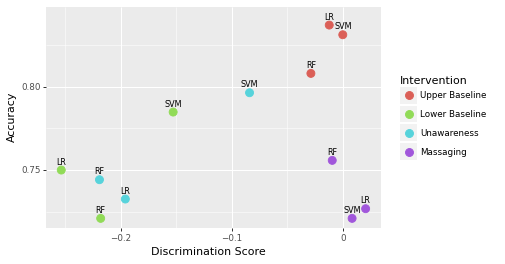

In [6]:
#all intervention+classifier combinations are applied and tested on the fair labels. The accuracy on these labels, as well as the discrimination score of the predictions
#are visualized in a scatterplot
test_classifier_on_train_test_split(X_biased, X_fair, categorical_attributes, test_on_fair_test_set = True, performance_measure_of_interest = "Accuracy", fairness_measure_of_interest = "Discrimination Score")
